# Imports

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from gan_package.gan import GAN
from gan_package.vanillaGAN import VanillaGAN_Generator, VanillaGAN_Discriminator
from gan_package.dcGAN import DCGAN_Generator, DCGAN_Discriminator

# Load MNIST dataset

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)),transforms.Normalize((0.5,), (0.5,))])
# dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Load LSUN dataset

In [ ]:
# Ścieżka do folderu z danymi LSUN
# dataset_path = "D:\\deep\\data0\\lsun\\bedroom"
dataset_path = 'lsun\\bedroom'

# Funkcja do odczytywania zdjęć z folderu
def load_images_from_folder(folder_path):
    images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    images.append(image)
    return images

def reshape_matrices(array):
    size_x = 256
    size_y = 256
    size_z = 3

    num_matrices = array.shape[0]
    reshaped_array = np.zeros((num_matrices, size_x, size_y, size_z))

    for i in range(num_matrices):
        reshaped_array[i] = np.resize(array[i], (size_x, size_y, size_z))

    # transpoze the last dimension to match the pytorch format
    reshaped_array = np.transpose(reshaped_array, (0, 3, 1, 2))

    return reshaped_array

# Przykładowe użycie
images = []
for folder1 in [0]:
    for folder2 in [0]:
        for folder3 in [0,1,2,3,4,5,6,7,8,9,'a','b','c','d','e','f']:
            print(os.path.join(dataset_path, str(folder1), str(folder2), str(folder3)))
            current_folder_path = os.path.join(dataset_path, str(folder1), str(folder2), str(folder3))
            images += load_images_from_folder(current_folder_path)

# preprocessing by resizing images to 64x64 and normalizing them
images = np.array(images)
images = images / 255.
images = reshape_matrices(images)

# convert images to tensors and torch.float32
import torch
images = torch.from_numpy(images)
images = images.type(torch.float32)

# Hyperparameters
lr = 0.0002
z_dim = 100
image_dim = 256 * 256 * 3
num_epochs = 10

In [26]:
# Prepare Dataloader
y = torch.ones(images.shape[0])
dataset = TensorDataset(images, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# Get shape of data, declare size of latent vector (from which we generate images)

In [27]:
IMG_SHAPE = dataloader.dataset[0][0].shape
N_OUT = torch.prod(torch.tensor(IMG_SHAPE))
LATENT_DIM = 100

# Instantiation of models, optimizers and loss

In [28]:
generator = VanillaGAN_Generator(latent_dim=LATENT_DIM, img_shape=IMG_SHAPE, n_out=N_OUT)
discriminator = VanillaGAN_Discriminator(img_shape=IMG_SHAPE)
gan = GAN(generator=generator, discriminator=discriminator)

criterion = nn.BCELoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Test of Generator output shape (if it is compatible with shape of original images)

In [81]:
latent_dim=100
num_channels=3
batch_size=64
img_shape = (3, 256, 256)
n_out = int(torch.prod(torch.tensor(img_shape)))
generator = VanillaGAN_Generator(latent_dim=latent_dim, 
                                 img_shape=img_shape, 
                                 n_out=n_out)

# Assume input shape: (batch_size, latent_dim)
input_shape = (batch_size, 100)

# Forward pass
output = generator(torch.randn(input_shape))

# Get the output shape
output_shape = output.shape

print(output_shape)

torch.Size([64, 3, 256, 256])


# Training loop

In [ ]:
gan.train(dataloader=dataloader,
          discriminator_optimizer=discriminator_optimizer,
          generator_optimizer=generator_optimizer,
          criterion=criterion,
          num_epochs=10)

In [84]:
# num_epochs = 10

# for epoch in range(num_epochs):
#     for real_images in tqdm(dataloader):
        
#         batch_size = real_images.size(0)
        
#         z = torch.randn(batch_size, LATENT_DIM)
#         fake_images = generator(z)
        
#         # Train the discriminator
#         d_loss = train_discriminator(optimizer=discriminator_optimizer, 
#                                      discriminator=discriminator, 
#                                      criterion=criterion,
#                                      real_images=real_images, 
#                                      fake_images=fake_images)
        
#         # Train the generator
#         fake_images_outputs = discriminator(fake_images)
        
#         g_loss = train_generator(optimizer=generator_optimizer, 
#                                  criterion=criterion, 
#                                  fake_images=fake_images, 
#                                  fake_images_outputs=fake_images_outputs)
        

 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

# Test generator power

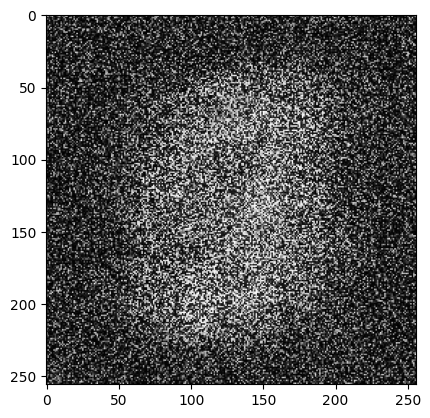

In [32]:
z = torch.randn(batch_size, LATENT_DIM)
fake_images = generator(z)
fake_image = fake_images[0].detach().numpy()
fake_image = fake_image.squeeze()

plt.imshow(fake_image, cmap='gray')
plt.show()